# Dynamic mode decomposition with control on a high-dimensional, linear system sparse in the Fourier space
Dynamic mode decomposition with control (DMDc) aims to disambiguate the effect of control/actuation
from the unforced dynamics.
We illustrate DMDc for system identification on a high-dimensional, linear system,
which intrinsic dynamics are low-dimensional in the Fourier space
(this is example 3 in Sec. 4 in Proctor et al., _"Dynamic Mode Decomposition with Control"_, SIAM 2016).

$$x_{k+1} =Ax_k + B u_k,\quad y_k = Cx_k$$

We first import the pyKoopman package and other packages for plotting and matrix manipulation.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.gridspec import GridSpec

import pykoopman as pk

Import torus example from the pyKoopman package.
This high-dimensional, linear system is characterized with few, active frequency components.
We further set parameters for the time discretization and use the default parameters
for the system.

In [11]:
np.random.seed(1) # for reproducibility
from pykoopman.common import torus_dynamics

show_movie = 0
T = 4          # integration time
dt = 0.01      # time step
n_samples = int(T/dt)


torus = torus_dynamics()
n_states = torus.n_states
print('Damping coefficients: ', torus.damping)
print('Frequencies: ', torus.frequencies)
print('Initial values: ',torus.IC)

Damping coefficients:  [-0.06704675 -0.04173048 -0.05586898 -0.01403869 -0.01981015]
Frequencies:  [1.29490465 1.65555972 0.90432793 1.87415841 0.33098395]
Initial values:  [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763]


The dynamical parameters are set for the unforced system
Create control matrix as a single point actuator in physical space

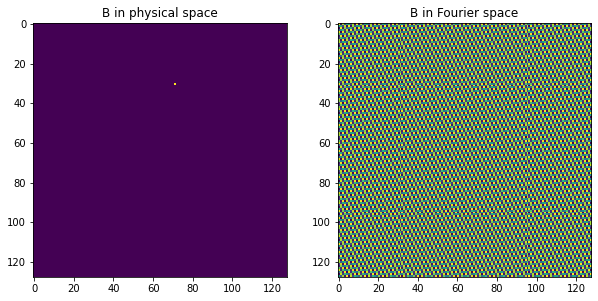

In [3]:
# Control matrix in physical space (single point actuator)
B = np.zeros((n_states, n_states))
B[np.random.randint(0, n_states, 1), np.random.randint(0, n_states, 1)] = 1
torus.set_control_matrix_physical(B)

# Control matrix in Fourier space
# Bhat = np.fft.fft2(B)
Bhat = torus.Bhat

fig = plt.figure(figsize=(10,20))
ax1 = plt.subplot2grid((1,2),(0,0), title='B in physical space')
ax1.imshow(np.real(B),interpolation='none', aspect='equal')
ax1 = plt.subplot2grid((1,2),(0,1), title='B in Fourier space')
ax1.imshow(np.real(Bhat),interpolation='none', aspect='equal')

Generate high-dimensional (and noise-corrupted) data, for which the underlying low-dimensional dynamics are governed by the above Fourier components.

In [4]:
# Random control inputs
U = 0.1*np.random.rand(n_samples)

torus.advance(n_samples, dt)
Xhat_ct = torus.Xhat

torus.advance_discrete_time(n_samples, dt, U)
Xhat_dt = torus.Xhat

Evolving continuous-time dynamics without control.


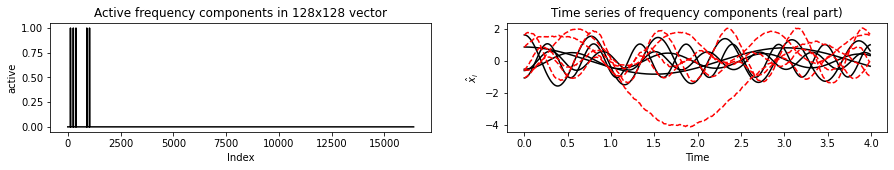

In [5]:
n_states = torus.n_states
xhat_ct = Xhat_ct[torus.mask.reshape(n_states**2)==1,:]
xhat_dt = Xhat_dt[torus.mask.reshape(n_states**2)==1,:]

fig = plt.figure(figsize=(15, 2))
ax = fig.add_subplot(121, title = 'Active frequency components in 128x128 vector')
ax.plot(torus.mask.reshape(n_states**2),'-', color='black')
ax.set(ylabel=r'active', xlabel='Index')

ax = fig.add_subplot(122, title = 'Time series of frequency components (real part)')
ax.plot(torus.time_vector,np.real(xhat_ct.T),'-', color='black', label='no control')
ax.set(ylabel=r'$\hat{x}_i$', xlabel='Time')
ax.plot(torus.time_vector,np.real(xhat_dt.T),'--', color='red', label='with control')

Compute true modes

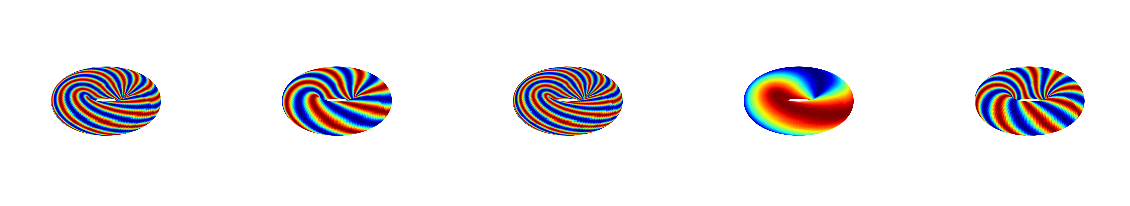

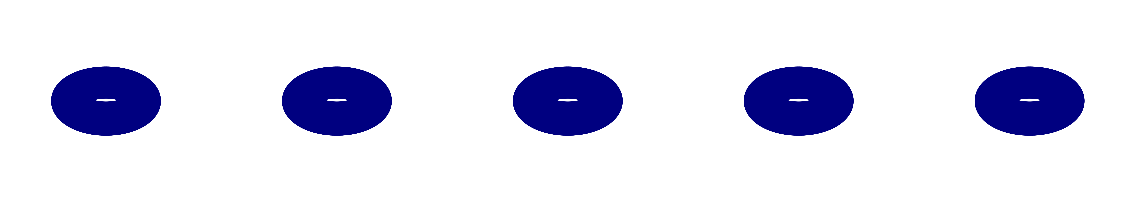

In [6]:
PhiTrue = torus.modes
torus.viz_all_modes(np.real(PhiTrue))
torus.viz_all_modes(np.imag(PhiTrue))

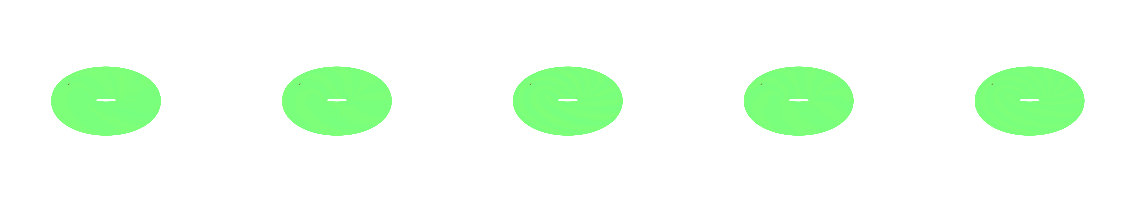

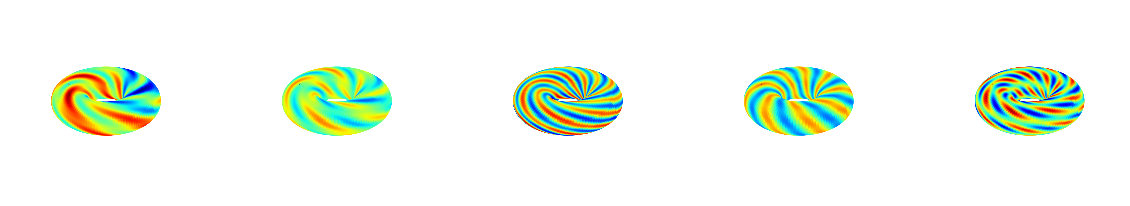

In [7]:
from pydmd import DMD
dmd = DMD(svd_rank=30)
model_dmd = pk.Koopman(regressor=dmd)
model_dmd.fit(torus.X.T)

Phi = model_dmd.regressor.regressor.modes
# modes#regressor.regressor.modes
torus.viz_all_modes(np.real(Phi[:,::2]))
torus.viz_all_modes(np.imag(Phi[:,::2])) # every other mode as they come in pairs

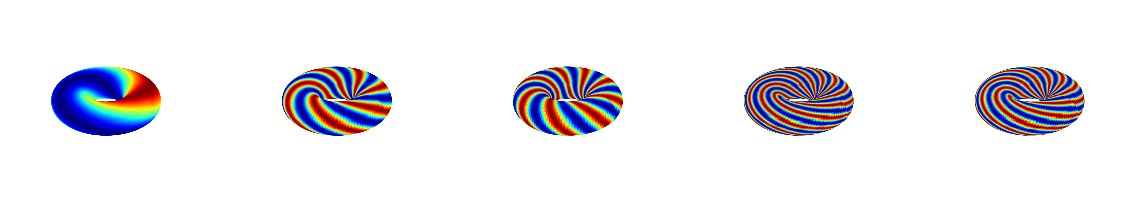

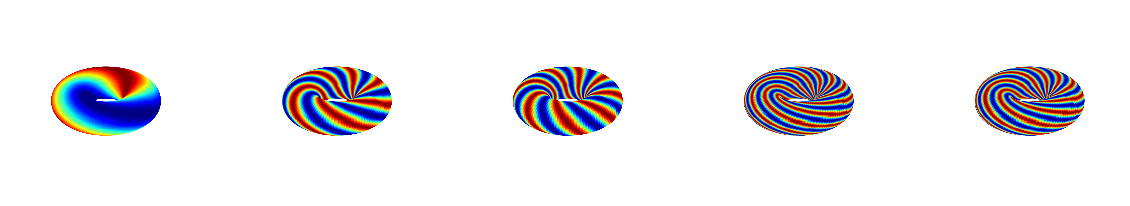

In [8]:
DMDc = pk.regression.DMDc(svd_rank=30, svd_output_rank=30)

model = pk.Koopman(regressor=DMDc)
model.fit(torus.X.T,U[:,np.newaxis]) #[:,np.newaxis]

Phi_dmdc = model.modes
torus.viz_all_modes(np.real(Phi_dmdc[:,::2]))
torus.viz_all_modes(np.imag(Phi_dmdc[:,::2]))

True

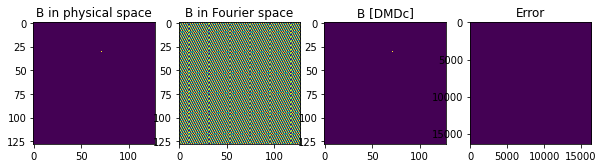

In [9]:
fig = plt.figure(figsize=(10,20))
ax1 = plt.subplot2grid((1,4),(0,0), title='B in physical space')
ax1.imshow(np.real(B),interpolation='none', aspect='equal')
ax1 = plt.subplot2grid((1,4),(0,1), title='B in Fourier space')
ax1.imshow(np.real(Bhat),interpolation='none', aspect='equal')
ax1 = plt.subplot2grid((1,4),(0,2), title='B [DMDc]')

Best = model.projection_matrix_output.dot(model.control_matrix)
ax1.imshow(np.real(Best.reshape(torus.n_states,torus.n_states)),interpolation='none', aspect='equal')

Bdiff = abs(B.reshape(torus.n_states**2)-Best)
# print(np.argmax(B.reshape(torus.n_states**2)), np.max(B.reshape(torus.n_states**2)))
# print(np.argmax(Best), np.max(Best))
# print(np.argmax(Bdiff), np.max(Bdiff))

ax1 = plt.subplot2grid((1,4),(0,3), title='Error')
ax1.imshow(np.real(Bdiff),interpolation='none', aspect='equal')
np.allclose(np.real(B),np.real(Best.reshape(torus.n_states,torus.n_states)))

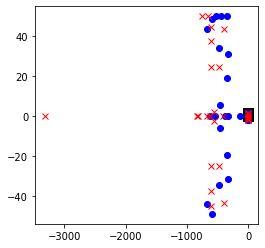

In [10]:
#TODO: dmd yields full stte matrix as Koopman_matrix
Admd = model_dmd.regressor.regressor.atilde
Admdc = model.state_transition_matrix

evals_dmd, evecs_dmd = np.linalg.eig(Admd)
evals_dmd_cont = np.log(evals_dmd)/dt

evals_dmdc, evecs_dmdc = np.linalg.eig(Admdc)
evals_dmdc_cont = np.log(evals_dmdc)/dt

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.plot(torus.damping, torus.frequencies,
        'sk', label='true', markersize=10)
ax.plot(evals_dmd_cont.real, evals_dmd_cont.imag/(2*np.pi), 'bo', label='dmd')
ax.plot(evals_dmdc_cont.real, evals_dmdc_cont.imag/(2*np.pi), 'xr', label='dmdc')



